In [82]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import torch

mimic_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\ehr_preprocess\\data\\processed\\mimic-iii-clinical-database-1.4"
# processed_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\patbert\\data\\processed\\mimic3\\plain"
raw_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\ehr_preprocess\\data\\raw\\mimic-iii-clinical-database-1.4"

## Patients

In [5]:
patients = pd.read_parquet(join(mimic_path,"patients_info.parquet"))
print(patients.GENDER.value_counts())
print(patients.DEATHDATE.notnull().sum(), 'dead patients')
cat_cols = ['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']
# for col in cat_cols:
    # patients[col] = patients[col].astype('category')

M    26121
F    20399
Name: GENDER, dtype: int64
15759 dead patients


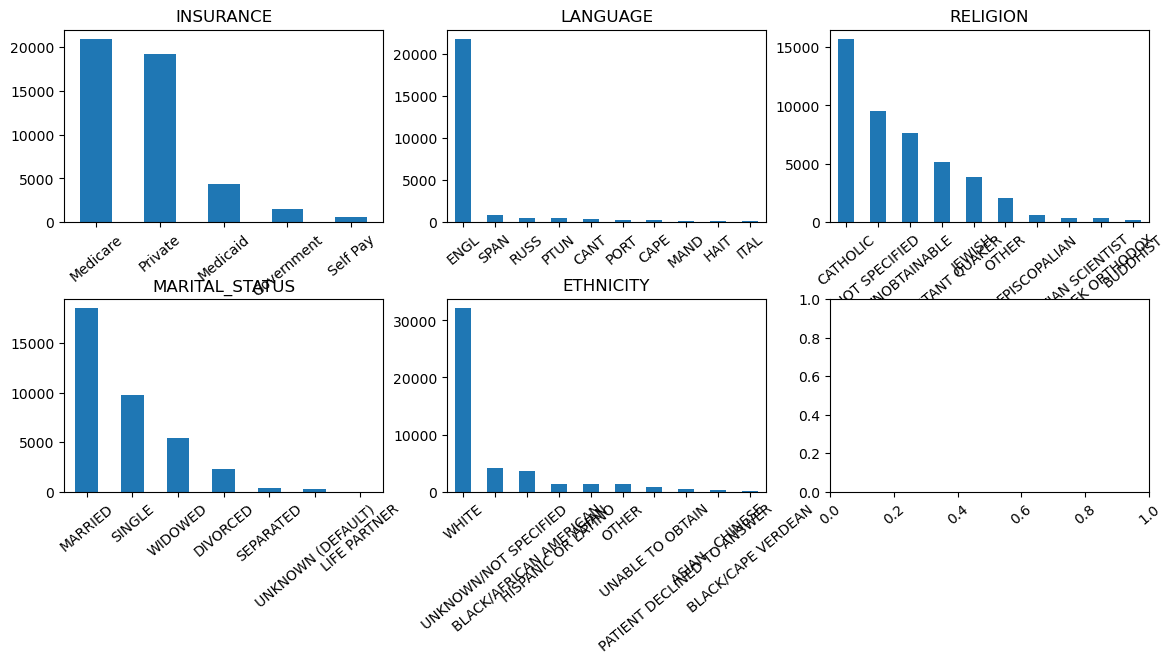

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    patients[col].value_counts()[:10].plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
# rotate xtick labels
for a in ax:
    for tick in a.get_xticklabels():
        tick.set_rotation(40)

# increase distance between subplots
fig.subplots_adjust(hspace=0.4)

<AxesSubplot: >

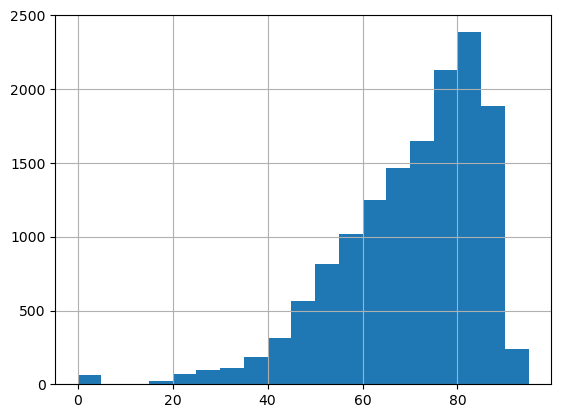

In [124]:
# compute average age of death
patients['death_age'] = patients.DEATHDATE.dt.date - patients.BIRTHDATE.dt.date
death_age = patients[patients.death_age.notnull()]['death_age'].map(lambda x: x.days / 365.25)
death_age.hist(bins=np.arange(0, 100, 5))

## Admissions

In [8]:
transfers = pd.read_parquet(join(mimic_path, "concept.transfer.parquet"))
transfers = transfers.reset_index(drop=True)

In [19]:
transfers.CONCEPT.value_counts()

TICU          61532
THOSPITAL     58976
TEMERGENCY    30877
Name: CONCEPT, dtype: int64

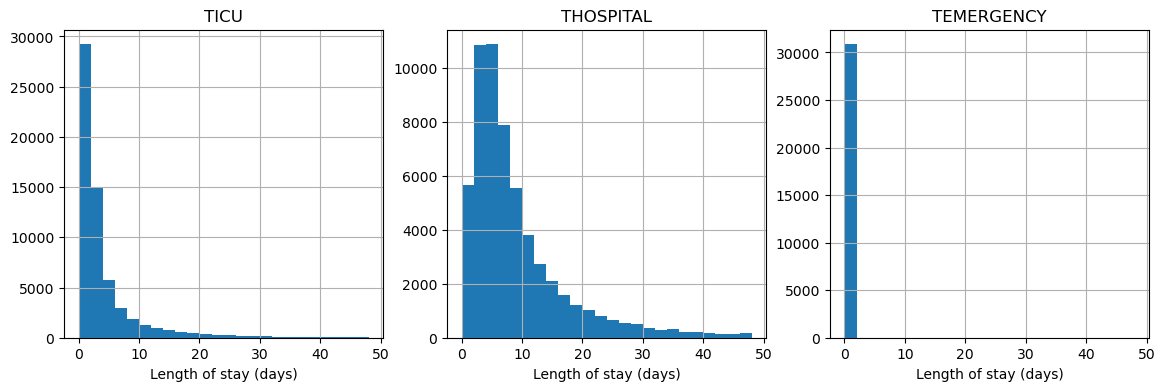

In [20]:
transfers['LOS'] = (transfers.TIMESTAMP_END - transfers.TIMESTAMP).map(lambda x: x.days)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(['TICU', 'THOSPITAL','TEMERGENCY']):
    transfers[transfers.CONCEPT==col]['LOS'].hist(ax=ax[i], bins=np.arange(0,50,2))
    ax[i].set_title(col)
    ax[i].set_xlabel('Length of stay (days)')

In [21]:
transfers.DISCHARGE_LOCATION.value_counts()

HOME                         18962
HOME HEALTH CARE             13963
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5854
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1534
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      365
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  63
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

In [22]:
transfers.ADMISSION_TYPE.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [23]:
transfers[transfers.PID.isin(transfers[transfers.CONCEPT=='TEMERGENCY'].PID)] # only events within same stay have a meaningful timeframe

,PID,ADMISSION_ID,TIMESTAMP,TIMESTAMP_END,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,CONCEPT,ICUSTAY_ID,LOS
2,3,145834,2101-10-20 17:09:00,2101-10-20 19:24:00,None,None,None,TEMERGENCY,<NA>,0.0
3,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,THOSPITAL,<NA>,10.0
4,3,145834,2101-10-20 19:10:11,2101-10-26 20:43:09,None,None,None,TICU,211552,6.0
5,4,185777,2191-03-15 13:10:00,2191-03-16 01:10:00,None,None,None,TEMERGENCY,<NA>,0.0
6,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,THOSPITAL,<NA>,7.0
...,...,...,...,...,...,...,...,...,...,...
151374,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,THOSPITAL,<NA>,16.0
151375,99985,176670,2181-01-29 05:33:34,2181-02-09 12:45:20,None,None,None,TICU,279638,11.0
151378,99992,197084,2144-07-25 13:40:00,2144-07-25 18:50:00,None,None,None,TEMERGENCY,<NA>,0.0
151379,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,THOSPITAL,<NA>,2.0


In [ ]:
transfers_end = transfers[transfers.TIMESTAMP_END.notnull(), ['PID', 'ADMISSION_ID', 'CONCEPT', 'TIMESTAMP_END']]


In [32]:
# we will separate THOSPITAL in categores based on ADMIT_TYPE
transfers.loc[transfers.CONCEPT=='THOSPITAL', 'CONCEPT'] = transfers.CONCEPT + '_' + transfers.ADMISSION_TYPE
transfers.CONCEPT.value_counts()
# this makes the EMERGENCY concept redundant

TICU                   61532
THOSPITAL_EMERGENCY    42071
TEMERGENCY             30877
THOSPITAL_NEWBORN       7863
THOSPITAL_ELECTIVE      7706
THOSPITAL_URGENT        1336
Name: CONCEPT, dtype: int64

In [34]:
transfers[(transfers.CONCEPT=='THOSPITAL_EMERGENCY') | (transfers.CONCEPT=='TEMERGENCY')]
# we should have the discharge location for the end event

,PID,ADMISSION_ID,TIMESTAMP,TIMESTAMP_END,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,CONCEPT,ICUSTAY_ID,LOS
2,3,145834,2101-10-20 17:09:00,2101-10-20 19:24:00,None,None,None,TEMERGENCY,<NA>,0.0
3,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,THOSPITAL_EMERGENCY,<NA>,10.0
5,4,185777,2191-03-15 13:10:00,2191-03-16 01:10:00,None,None,None,TEMERGENCY,<NA>,0.0
6,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,THOSPITAL_EMERGENCY,<NA>,7.0
17,9,150750,2149-11-09 11:13:00,2149-11-09 13:18:00,None,None,None,TEMERGENCY,<NA>,0.0
...,...,...,...,...,...,...,...,...,...,...
151371,99983,117390,2193-04-26 11:35:00,2193-04-29 13:30:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,THOSPITAL_EMERGENCY,<NA>,3.0
151373,99985,176670,2181-01-26 23:35:00,2181-01-27 04:18:00,None,None,None,TEMERGENCY,<NA>,0.0
151374,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,THOSPITAL_EMERGENCY,<NA>,16.0
151378,99992,197084,2144-07-25 13:40:00,2144-07-25 18:50:00,None,None,None,TEMERGENCY,<NA>,0.0


TEMERGENCY can be combined with hospital admission, since every emergency admissions is also a hospital admission


## Diagnoses

In [65]:
diag = pd.read_parquet(join(mimic_path, "concept.diag.parquet"))
print(len(diag), diag.CONCEPT.nunique())

651047 6985


Text(0.5, 0, 'Number of diagnoses per patient')

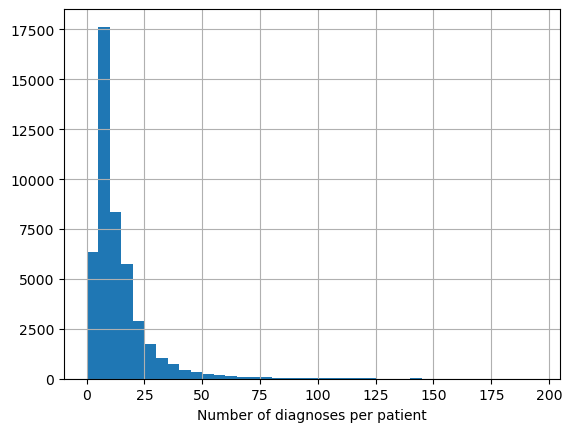

In [30]:
diag.groupby('PID').CONCEPT.count().sort_values( ascending=False).hist(bins=np.arange(0, 200, 5))
plt.xlabel('Number of diagnoses per patient')

Text(0.5, 0, 'Frequency of diagnosis')

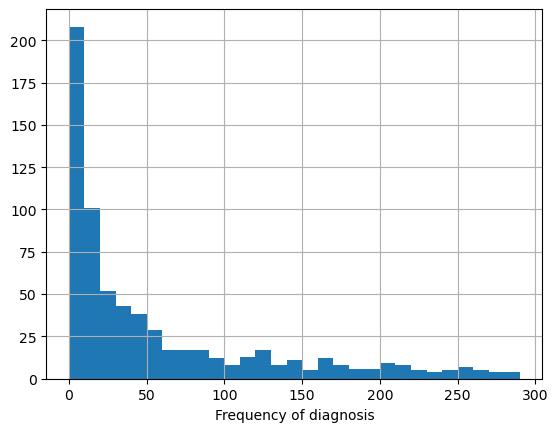

In [152]:
# group diagnosis 
diag['CONCEPT_GROUP'] = diag.CONCEPT.map(lambda x: x[:4])
diag.CONCEPT_GROUP.value_counts().hist(bins=np.arange(0, 300, 10))
plt.xlabel('Frequency of diagnosis')

## Procedures

In [61]:
pro = pd.read_parquet(join(mimic_path, "concept.pro.parquet"))
print(len(pro), pro.CONCEPT.nunique())
pro.head()

240095 2009


,PID,ADMISSION_ID,VALUE,CONCEPT,TIMESTAMP,VALUE_UNIT
0,2,163353,1,P9955,2138-07-21 15:48:00,SEQ_NUM
1,3,145834,1,P9604,2101-10-31 13:58:00,SEQ_NUM
2,3,145834,2,P9962,2101-10-31 13:58:00,SEQ_NUM
3,3,145834,3,P8964,2101-10-31 13:58:00,SEQ_NUM
4,3,145834,4,P9672,2101-10-31 13:58:00,SEQ_NUM


Text(0.5, 0, 'Number of procedures')

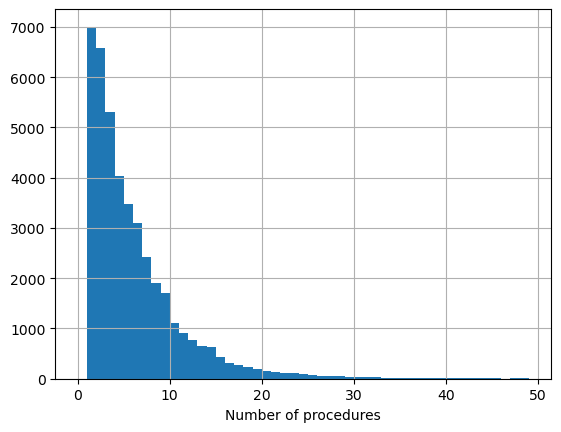

In [162]:
pro.groupby('PID').CONCEPT.count().sort_values( ascending=False).hist(bins=np.arange(0, 50, 1))
plt.xlabel('Number of procedures')

## Medication

In [25]:
med = pd.read_parquet(join(mimic_path, "concept.med.parquet"))
print(len(med), med.CONCEPT.nunique())
med.head()

4156450 4525


,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,CONCEPT,VALUE,VALUE_UNIT
0,2,163353,243653,2138-07-18,MAmpicillin Sodium,500,mg
1,2,163353,243653,2138-07-18,MNEO*IV*Gentamicin,15.5,mg
2,2,163353,243653,2138-07-18,MSend 500mg Vial,1,VIAL
3,2,163353,243653,2138-07-18,MSyringe (Neonatal) *D5W*,2.4,ml
4,4,185777,294638,2191-03-16,MAcetaminophen,325-650,mg


<AxesSubplot: >

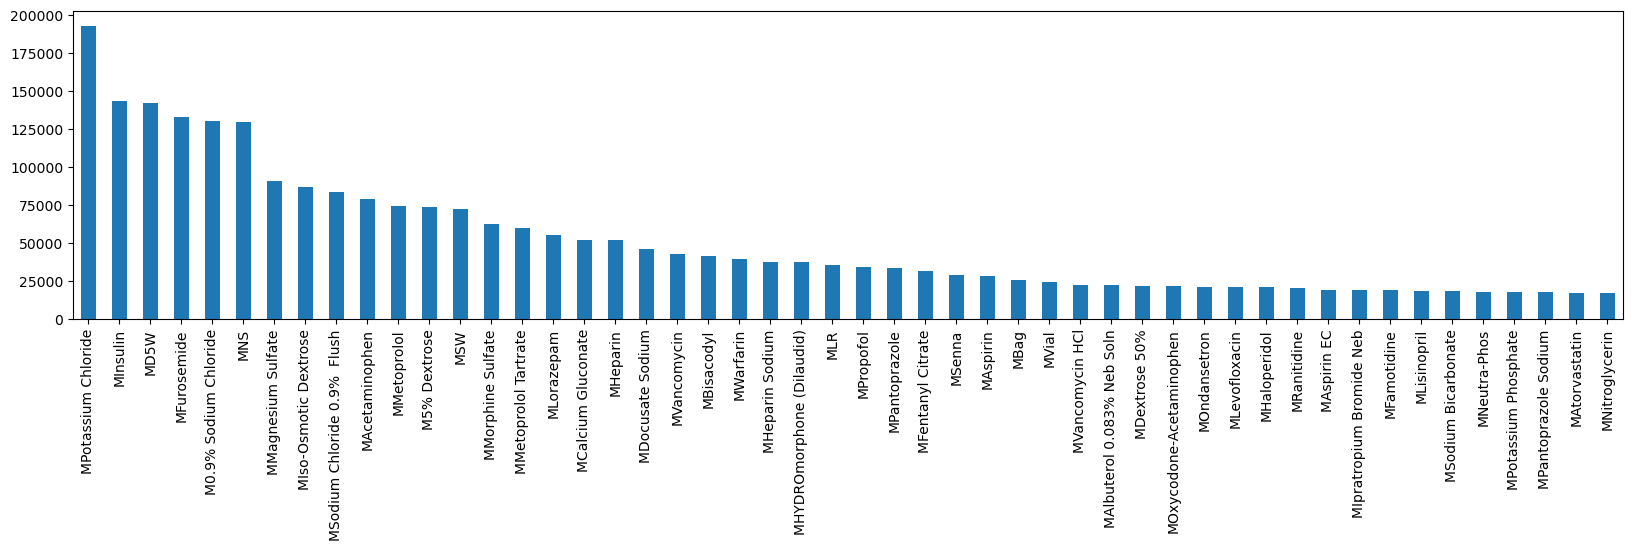

In [26]:
fig, ax = plt.subplots(figsize=(20, 4))
med.CONCEPT.value_counts()[:50].plot(kind='bar',ax=ax)

c:\users\fjn197\phd\projects\phair\pipelines\patbert\patbert\data\utils.py:10: UserWarning: The "similarity" argument is deprecated since dirty_cat 0.3, and will be removed in 0.5.The n-gram similarity is the only one currently supported. 
  enc = SimilarityEncoder()
c:\Users\fjn197\Miniconda3\envs\patbert\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


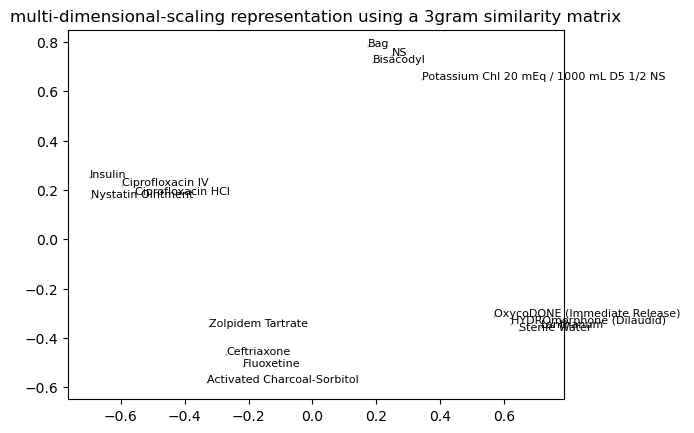

In [230]:
utils.visualize_encoded(med.sample(500), 'CONCEPT', n_points=4, n_neighbors=4)

## Weight

In [266]:
weight = pd.read_parquet(join(mimic_path, "concept.weight.parquet"))
print(len(weight))
weight.head()

3618991


,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,VALUE,CONCEPT,VALUE_UNIT
0,27063,139787,223259,2133-02-05 06:29:00,83.2,WWEIGHT,kg
1,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg
2,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg
3,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg
4,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg


Text(0.5, 0, 'Number of unique values per patient')

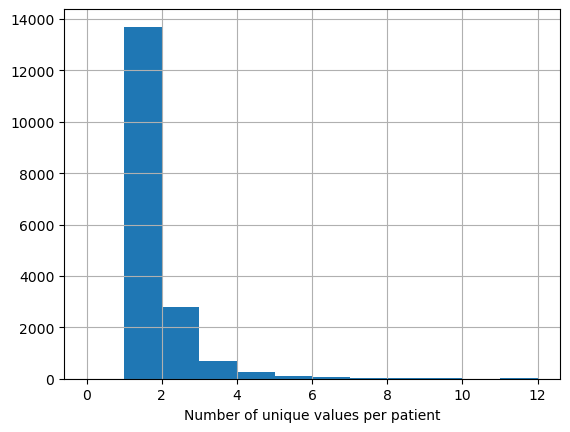

In [267]:
# visualize a hist of unique values per patient
weight.groupby('PID').VALUE.nunique().hist(bins=np.arange(0, 12.5, 1))
plt.xlabel('Number of unique values per patient')

Text(0.5, 0, 'Mean weight (kg)')

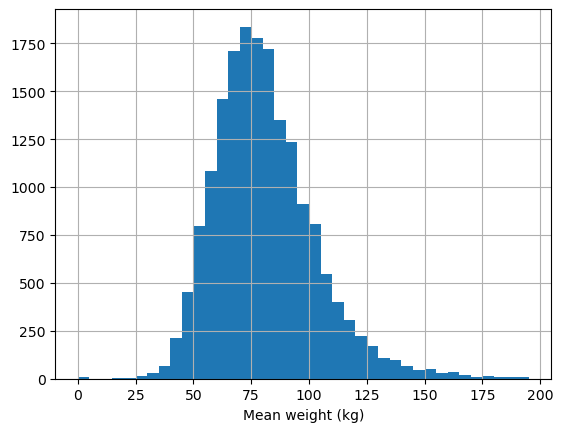

In [268]:
# histogram of mean patient weight
weight.groupby('PID').VALUE.mean().hist(bins=np.arange(0, 200, 5))
plt.xlabel('Mean weight (kg)')

Text(0.5, 0, 'Number of measurements per patient')

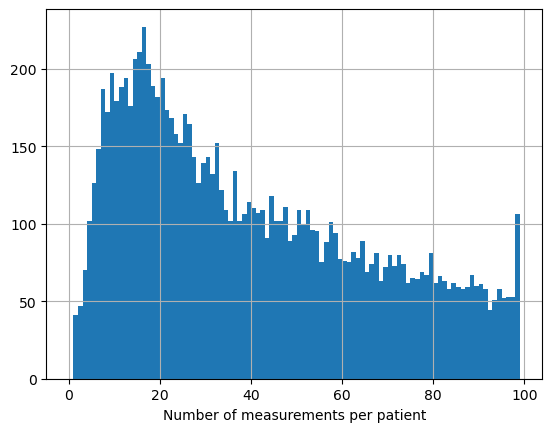

In [269]:
# number of measurements per patient
weight.groupby('PID').VALUE.count().hist(bins=np.arange(0, 100, 1))
plt.xlabel('Number of measurements per patient')

In [270]:
weight['weight_diff'] = weight.groupby('PID').VALUE.diff()
weight

,PID,ADMISSION_ID,ICUSTAY_ID,TIMESTAMP,VALUE,CONCEPT,VALUE_UNIT,weight_diff
0,27063,139787,223259,2133-02-05 06:29:00,83.2,WWEIGHT,kg,NaN
1,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg,0.0
2,27063,139787,223259,2133-02-05 05:34:00,83.2,WWEIGHT,kg,0.0
3,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg,0.0
4,27063,139787,223259,2133-02-03 12:00:00,83.2,WWEIGHT,kg,0.0
...,...,...,...,...,...,...,...,...
3618986,90959,136680,240741,2147-08-28 12:00:00,96.0,WWEIGHT,kg,0.0
3618987,90959,136680,240741,2147-08-29 12:16:00,96.0,WWEIGHT,kg,0.0
3618988,90959,136680,240741,2147-08-29 12:16:00,96.0,WWEIGHT,kg,0.0
3618989,90959,136680,240741,2147-08-29 02:30:00,96.0,WWEIGHT,kg,0.0


In [272]:
weight = weight[weight.weight_diff!=0]
# many consecutive measurements are the same

## Labevents

In [177]:
lab = pd.read_parquet(join(mimic_path, "concept.lab.parquet")).sample(int(1e6))
print(len(lab), lab.CONCEPT.nunique())
lab.head()

1000000 578


,PID,ADMISSION_ID,TIMESTAMP,VALUE,VALUE_UNIT,CONCEPT
26455961,89447,159159,2148-01-31 08:55:00,4750,#/uL,L26457-2
11088418,17944,<NA>,2176-03-29 17:14:00,NEG,mg/dL,L5818-0
8693592,14031,<NA>,2174-07-04 09:45:00,6.9,%,L742-7
3575935,5712,178657,2110-08-26 05:55:00,2.6,None,L5895-7
3117583,4967,<NA>,2180-12-19 14:40:00,NEG,mg/dL,L5792-7


<AxesSubplot: >

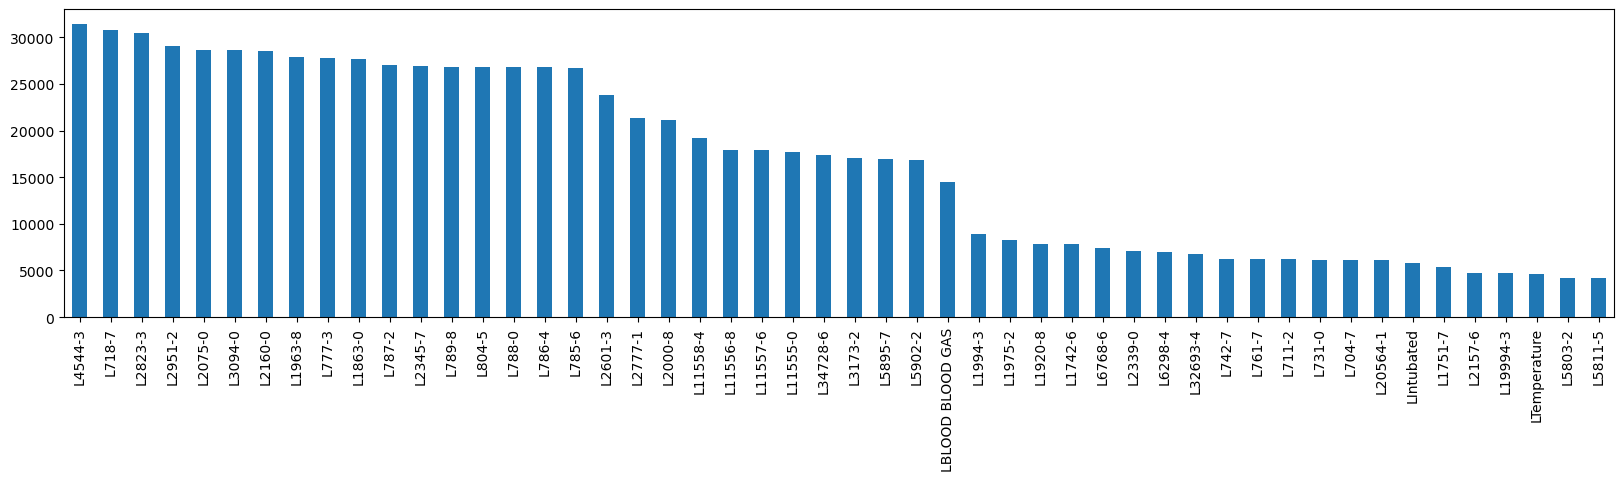

In [178]:
fig, ax = plt.subplots(figsize=(20, 4))
lab.CONCEPT.value_counts()[:50].plot(kind='bar',ax=ax)

### example outcomes for lab tests

In [206]:
for key in lab.CONCEPT.value_counts()[:3].keys():
    lab0 = lab[lab.CONCEPT==key]
    lab0 = lab0[lab0.VALUE.notnull()]
    lab0 = lab0[~lab0.VALUE.str.replace('.','').str.isnumeric()]
    print(lab0.VALUE.value_counts())

ERROR    3
Name: VALUE, dtype: int64
DONE                               132
ERROR                                5
UNABLE TO PERFORM                    1
UNABLE TO REPORT                     1
NOT DONE                             1
UNABLE TO REPORT DUE TO LIPEMIA      1
Name: VALUE, dtype: int64
GREATER THAN 10.0               5
GREATER THAN 10                 3
>10                             1
HEMOLYSIS FALSELY ELEVATES K    1
ERROR                           1
>10.0                           1
Name: VALUE, dtype: int64


C:\Users\fjn197\AppData\Local\Temp\ipykernel_18612\114695827.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  lab0 = lab0[~lab0.VALUE.str.replace('.','').str.isnumeric()]
C:\Users\fjn197\AppData\Local\Temp\ipykernel_18612\114695827.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  lab0 = lab0[~lab0.VALUE.str.replace('.','').str.isnumeric()]
C:\Users\fjn197\AppData\Local\Temp\ipykernel_18612\114695827.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  lab0 = lab0[~lab0.VALUE.str.replace('.','').str.isnumeric()]


C:\Users\fjn197\AppData\Local\Temp\ipykernel_18612\1519218151.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  lab0 = lab0[lab0.VALUE.str.replace('.',',').str.isnumeric()]


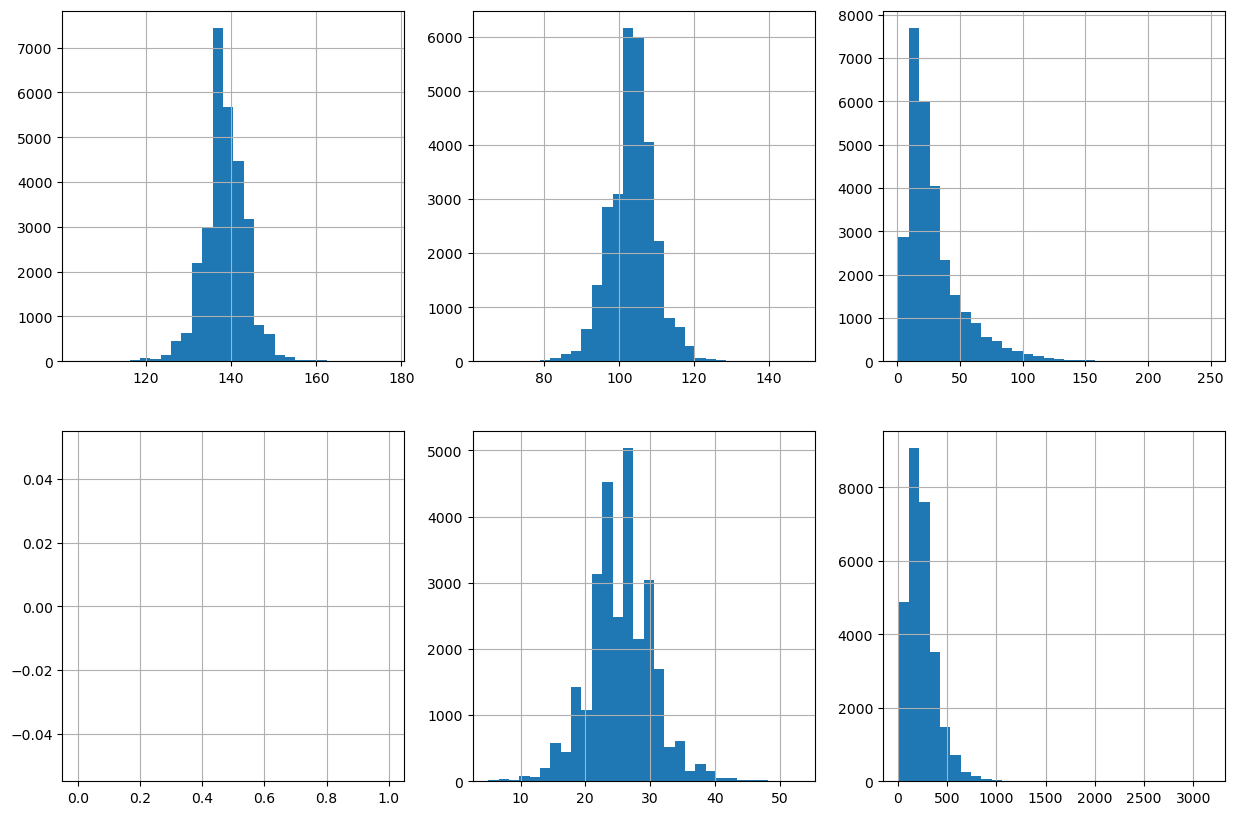

In [209]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
axs = axs.flatten()
for key, ax in zip(lab.CONCEPT.value_counts()[3:9].keys(), axs):
    lab0 = lab[lab.CONCEPT==key]
    # remove non-numeric values
    lab0 = lab0[lab0.VALUE.notnull()]
    lab0 = lab0[lab0.VALUE.str.replace('.',',').str.isnumeric()]
    lab0.VALUE.astype(float).hist(bins=30, ax=ax)

In [96]:
lab0.VALUE.astype(float).hist(bins=np.arange(0, 100, 1))

ValueError: could not convert string to float: 'ERROR,PREVIOUSLY REPORTED AS26.5'

Text(0.5, 0, 'Number of measurements per patient')

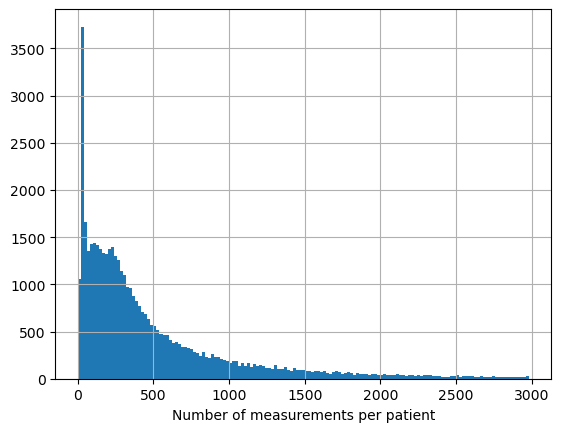

In [11]:
# number of measurements per patient
lab.groupby('PID').VALUE.count().hist(bins=np.arange(0, 3000, 20))
plt.xlabel('Number of measurements per patient')

## Chartevents

In [87]:
chart = pd.read_parquet(join(mimic_path, "concept.chartevent.parquet"))
print(len(chart), chart.CONCEPT.nunique())
chart.head()

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
lab.CONCEPT.value_counts()[:50].plot(kind='bar',ax=ax)

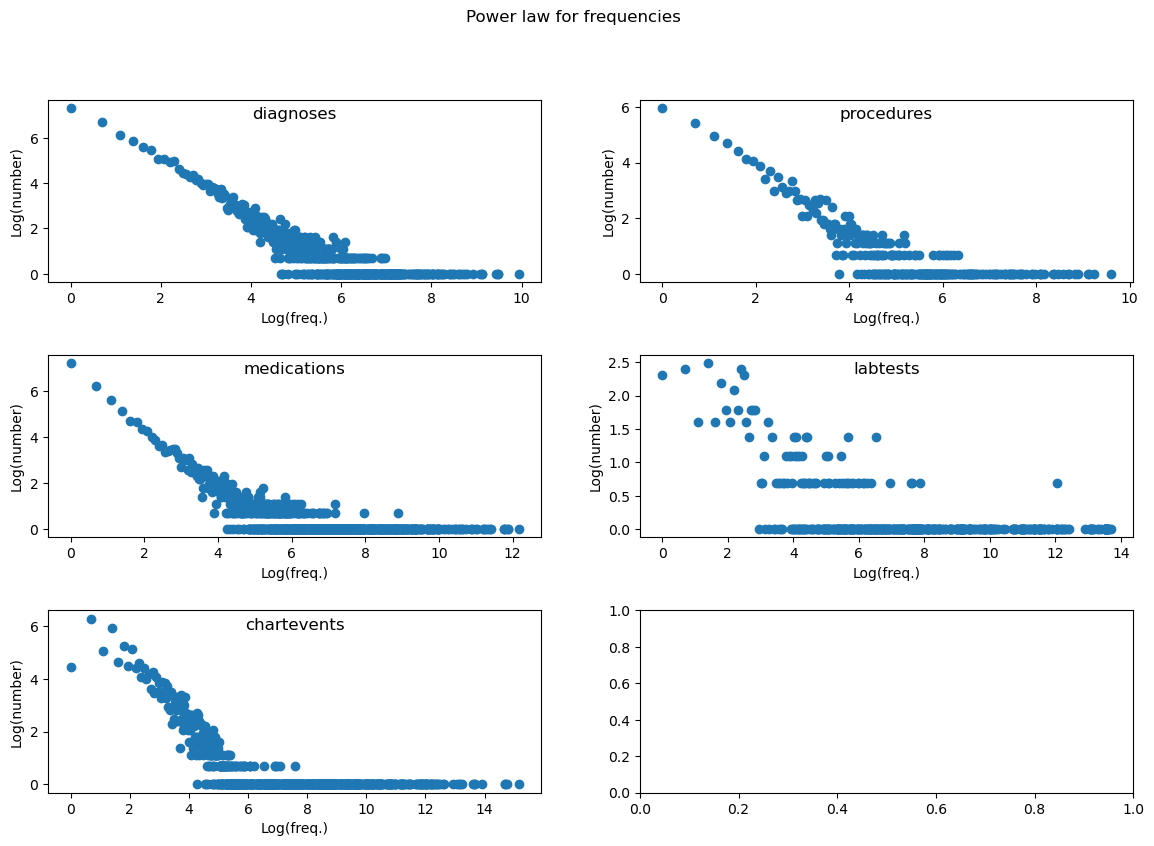

In [86]:
fig, axs = plt.subplots(3,2, figsize=(14, 9))
axs = axs.flatten()
for ax, df, name in zip(axs, [diag, pro, med, lab, chart], ['diagnoses', 'procedures', 'medications', 'labtests', 'chartevents']):
    utils.zipfs_law_plot(df, ax, name)
fig.suptitle(f'Power law for frequencies')
# increase vertical distance between subplots
fig.subplots_adjust(hspace=0.4)